To execute this notebook, you need to either
 - Download a pre-trained model
 - Train an example model by excecuting the model_training_tutorial.ipynb notebook

In this tutorial we will learn to:
- Load a previously trained model
- Extract DeepPrint features from fingerprint images
- Evaluate the performance of the extracted fixed-length representations

## Embedding extraction

After training the model, we can extract the DeepPrint features for the fingerprint images. This is done by calling the `extract` method of the `DeepPrintExtractor` class.

In [11]:
import sys
import os
# 获取Notebook所在目录（notebooks/）
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
# 项目根目录 = notebooks/ 的上一级目录
project_root = os.path.dirname(notebook_dir)
# 将项目根目录加入sys.path
sys.path.append(project_root)

from flx.extractor.fixed_length_extractor import get_DeepPrint_Tex, get_DeepPrint_TexMinu, DeepPrintExtractor

# Dimension and number of training subjects must be known to load the pre-trained model

# To load the pre-trained model parameters use num_training_subjects=8000
extractor: DeepPrintExtractor = get_DeepPrint_TexMinu(num_training_subjects=8000, num_dims=256)

# To load the pre-trained model parameters use
MODEL_DIR: str = os.path.abspath("example-model") # Path to the directory containing the model parameters
extractor.load_best_model(MODEL_DIR)

Loaded best model from d:\AAAduYan\ZhiWen\Xin12_4\fixed-length-fingerprint-extractors\notebooks\example-model\best_model.pyt


Now we need to specify the dataset, for which we want to extract the embeddings

In [12]:
import os

from flx.data.dataset import *
from flx.setup.datasets import get_fvc2004_db1a
from flx.data.image_loader import SFingeLoader
from flx.data.transformed_image_loader import TransformedImageLoader
from flx.image_processing.binarization import LazilyAllocatedBinarizer
from flx.data.image_helpers import pad_and_resize_to_deepprint_input_size

FVC_DB1A_DIR=r"D:\AAAduYan\ZhiWen\Xin12_4\fixed-length-fingerprint-extractors\data\fingerprints\FVC2000\Dbs\Db1_a"
fvc_dataset = get_fvc2004_db1a(FVC_DB1A_DIR)
'''
# NOTE: If this does not work, enter the absolute path to the notebooks/example-dataset directory here! 
DATASET_PATH: str = os.path.abspath("example-dataset")

# We will use the SFingeLoader to load the images from the dataset
image_loader = TransformedImageLoader(
        images=SFingeLoader(DATASET_PATH),
        poses=None,
        transforms=[
            LazilyAllocatedBinarizer(5.0),
            pad_and_resize_to_deepprint_input_size,
        ],
    )

image_dataset: Dataset = Dataset(image_loader, image_loader.ids)
'''
# The second value is for the minutiae branch, which we do not have in this example
texture_embeddings, minutia_embeddings = extractor.extract(fvc_dataset)



Created IdentifierSet with 100 subjects and a total of 800 samples.


100%|██████████| 25/25 [12:32<00:00, 30.08s/it]


## Benchmarking

To evaluate the embeddings, we want to run a benchmark on them. For this, we must first specify the type of benchmark, and which comparisons should be run.

In [ ]:
from flx.scripts.generate_benchmarks import create_verification_benchmark

NUM_IMPRESSIONS_PER_SUBJECT = 8
benchmark = create_verification_benchmark(
    subjects=list(range(fvc_dataset.num_subjects)),
    impressions_per_subject=list(range(NUM_IMPRESSIONS_PER_SUBJECT))
)



100%|██████████| 100/100 [00:00<00:00, 8334.77it/s]


'\nfrom flx.scripts.generate_benchmarks import create_verification_benchmark\n\n# 从 dataset 里统计真实的 subject 和 impression 编号\nsubjects = sorted({id.subject for id in image_loader.ids})\nimpressions = sorted({id.impression for id in image_loader.ids})\n\nprint("subjects:", subjects)\nprint("impressions:", impressions)\n\nbenchmark = create_verification_benchmark(\n    subjects=subjects,\n    impressions_per_subject=impressions,\n)\n'

Now we can run the benchmark. To do this, we must first specify the matcher (in our case cosine similarity of the embeddings)

In [74]:
from flx.benchmarks.matchers import CosineSimilarityMatcher
from flx.data.embedding_loader import EmbeddingLoader

# We concatenate texture and minutia embedding vectors
embeddings = EmbeddingLoader.combine(texture_embeddings, minutia_embeddings)
matcher = CosineSimilarityMatcher(EmbeddingLoader.combine(texture_embeddings, minutia_embeddings))

results = benchmark.run(matcher)

print(f"Equal-Error-Rate: {results.get_equal_error_rate()}")
thresholds = [1.6,1.615,1.625,1.63,1.831]
fnmr_values = results.false_non_match_rate(thresholds)
for i, threshold in enumerate(thresholds):
    print(f"阈值 {threshold}: FFR = {fnmr_values[i]:.4f}")
fmr_values = results.false_match_rate(thresholds)
for i, threshold in enumerate(thresholds):
    print(f"阈值 {threshold}: FAR = {fmr_values[i]:.6f}")

Created IdentifierSet with 100 subjects and a total of 800 samples.
Created IdentifierSet with 100 subjects and a total of 800 samples.
Created IdentifierSet with 100 subjects and a total of 800 samples.
Created IdentifierSet with 100 subjects and a total of 800 samples.
Created IdentifierSet with 100 subjects and a total of 800 samples.
Created IdentifierSet with 100 subjects and a total of 800 samples.


100%|██████████| 9200/9200 [00:00<00:00, 176485.16it/s]

Equal-Error-Rate: 0.02875
阈值 1.6: FFR = 0.0393
阈值 1.615: FFR = 0.0479
阈值 1.625: FFR = 0.0493
阈值 1.63: FFR = 0.0518
阈值 1.831: FFR = 0.2468
阈值 1.6: FAR = 0.019375
阈值 1.615: FAR = 0.016875
阈值 1.625: FAR = 0.015469
阈值 1.63: FAR = 0.014531
阈值 1.831: FAR = 0.000156


To visualize the results, we can plot a DET curve. (Do not wonder if it is empty, probably the model is not trained enough. Take a look at the EER instead.)

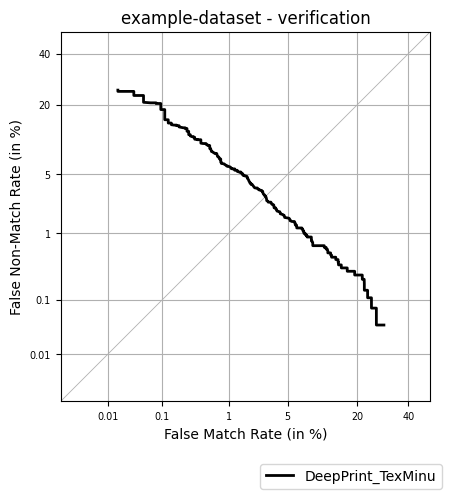

In [15]:
from flx.visualization.plot_DET_curve import plot_verification_results

figure_path = "DET_curve"

# Lists are used to allow for multiple models to be plotted in the same figure
plot_verification_results(figure_path, results=[results], model_labels=["DeepPrint_TexMinu"], plot_title="example-dataset - verification")